In [105]:
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

# Use this to test 

# This workbook minic the code from tensorflow specialization study
# 1. use tokenizer
# 2. use flatten layer
# 3. use early stopping 
# 4. tested that sklearn and keras return same precision, recall, accuracy
# 5. use model structure with dense(6) before dense(1) + faltten(), best model accuracy = 0.79; seems like the model is over trained
# 6. use model structure with global1d + dense(1), best model accuracy = 0.80; it is just a slight improvement
# 7. also tried using the flatten + dense(1), model is in 0.79 range

In [106]:
df = pd.read_csv('train.csv', dtype =object,  usecols= ['id', 'text', 'target'])
df['target'] = df['target'].astype(float)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)
# target = df.pop('target')

In [135]:
vocab_size = 10000
embedding_dim = 16

max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df_train['text'])
word_index = tokenizer.word_index

# use index method 

# they are two methods here: use text to sequences, then use embedding layer to create the word embedding; 
# or directly convert each document to a vector
training_sequences = tokenizer.texts_to_sequences(df_train['text'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(df_test['text'])
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# training_vectors = tokenizer.texts_to_matrix(df_train['text'], mode='binary')
# # training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)
# testing_vectors = tokenizer.texts_to_sequences(df_test['text'], mode = 'binary')
# # testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


# this still may be converted to a vectorization layer

In [137]:
training_sequences.shape

(6090, 10000)

In [108]:
print('embedding_dim:' +  str(embedding_dim))
print('embedding_dim:' +  str(max_length))

embedding_dim:16
embedding_dim:120


In [127]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(), # either this one, or use the global average pooling 1d
#     tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# optimizer = tf.keras.optimizers.Adam(lr=0.001)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), 
                                                                   tf.keras.metrics.Recall()])
model.summary()

# how to add in precision and recall? 


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
flatten_16 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 1921      
Total params: 161,921
Trainable params: 161,921
Non-trainable params: 0
_________________________________________________________________


In [142]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# model = tf.keras.Sequential([tf.keras.layers.Input(10000,),
# #     tf.keras.layers.Dense(6, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.Adam()
# model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), 
#                                                                    tf.keras.metrics.Recall()])
# model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [128]:
num_epochs = 30
history = model.fit(training_padded, df_train['target'], epochs=num_epochs, validation_data=(testing_padded, df_test['target']),
                   callbacks=[callback])

Epoch 1/30
191/191 [==============================] - 1s 2ms/step - loss: 0.6761 - accuracy: 0.5695 - precision_19: 0.5134 - recall_16: 0.2355 - val_loss: 0.6059 - val_accuracy: 0.6809 - val_precision_19: 0.6636 - val_recall_16: 0.5393
Epoch 2/30
191/191 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.7384 - precision_19: 0.7405 - recall_16: 0.5922 - val_loss: 0.4954 - val_accuracy: 0.7846 - val_precision_19: 0.8584 - val_recall_16: 0.6042
Epoch 3/30
191/191 [==============================] - 0s 1ms/step - loss: 0.3848 - accuracy: 0.8575 - precision_19: 0.9224 - recall_16: 0.7270 - val_loss: 0.4611 - val_accuracy: 0.7925 - val_precision_19: 0.8289 - val_recall_16: 0.6586
Epoch 4/30
191/191 [==============================] - 0s 1ms/step - loss: 0.2880 - accuracy: 0.9008 - precision_19: 0.9368 - recall_16: 0.8248 - val_loss: 0.4599 - val_accuracy: 0.7991 - val_precision_19: 0.8410 - val_recall_16: 0.6631
Epoch 5/30
191/191 [==============================] - 0s

In [129]:
# continue from here 

In [130]:
test_target_pred = (model.predict(testing_padded) > 0.5).astype(int)
# test_target_pred_class = model.predict_classes(testing_padded)

In [131]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print('accuracy: ' + str(accuracy_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('precision: ' +  str(precision_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('recall: ' + str(recall_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('f1: ' +  str(f1_score(y_pred=test_target_pred, y_true=df_test['target'])))
print('auc: ' +  str(roc_auc_score(y_score=test_target_pred, y_true=df_test['target'])))


accuracy: 0.7951411687458962
precision: 0.8277153558052435
recall: 0.6676737160120846
f1: 0.7391304347826088
auc: 0.7804106094578425


In [120]:
model.metrics_names

['loss', 'accuracy', 'precision_18', 'recall_15']

In [123]:
loss, accuracy, precision, recall = model.evaluate(x=testing_padded, y = df_test['target'])

print("Loss: ", loss)
print("Accuracy: ", accuracy)
print('precision: ', precision)
print('recall: ', recall)


48/48 [==============================] - 0s 579us/step - loss: 0.4503 - accuracy: 0.8024 - precision_18: 0.8312 - recall_15: 0.6843
Loss:  0.4502756893634796
Accuracy:  0.8023637533187866
precision:  0.831192672252655
recall:  0.6842900514602661


In [132]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision_19', 'recall_16', 'val_loss', 'val_accuracy', 'val_precision_19', 'val_recall_16'])

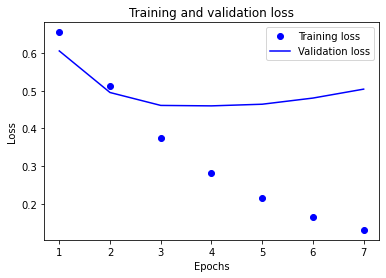

In [133]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

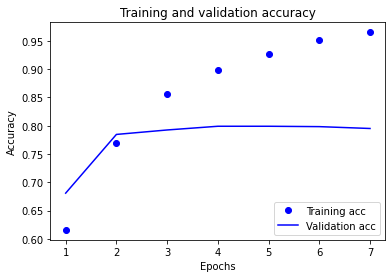

In [134]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [74]:
# for ele, text in ds_test_raw.take(-1):
#     print(ele)

# t = ds_test_raw.map(lambda x, y: x.numpy())